In [1]:
from glob import glob
import os, re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import yaml
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## sanitized policy with n=32768

In [2]:
stream = open('../params.yml', 'r')
mydict = yaml.full_load(stream)

base_dir = mydict['folder']
base_input_dir = os.path.join(base_dir, 'test_outputs')

### load performance data for a fixed n and varying d

In [3]:
all_dir_list = os.listdir(base_input_dir)
all_dimensions_base_dir = list(filter(lambda x: 'clean_sample_32768_with' in x, all_dir_list)) 

string_num_dict = {}
for top_d_dir in all_dimensions_base_dir:
    num = [int(num) for num in re.findall('[0-9]+', top_d_dir)][1]
    string_num_dict[num] = top_d_dir

sanitizing_sample_count_list = []
sorted_dic = collections.OrderedDict(sorted(string_num_dict.items()))
for key, value in sorted_dic.items():
    sanitizing_sample_count_list.append(key)


In [4]:
sample_trial_return_mean_list, sample_trial_return_std_list = [], []
for k, (top_d, top_d_basis_dir) in enumerate(sorted_dic.items()):
    
    sample_base_dir = os.path.join(base_input_dir, top_d_basis_dir, 'sanitized/poison_2000')  
    return_mean_list = []
    for trial in os.listdir(sample_base_dir):
        
        trial_csv_file = os.path.join(sample_base_dir, trial, 'log', 'csv_data.csv')
        if(not os.path.exists(trial_csv_file)):
            continue 

        results_csv = pd.read_csv(trial_csv_file)
        return_str = results_csv.loc[results_csv.shape[0]-1, 'return_list']
        return_list = [int(num) for num in re.findall('[0-9]+', return_str)]
        
        return_mean, return_std = np.mean(return_list), np.std(return_list)
        return_mean_list.append(return_mean)
        
    sample_trial_return_mean_list.append(np.mean(return_mean_list)), sample_trial_return_std_list.append(np.std(return_mean_list))

In [5]:
sanitizing_sample_count_list = sanitizing_sample_count_list[:30]
st_return_mean_list = sample_trial_return_mean_list[:30]
st_return_std_list = sample_trial_return_mean_list[:30]
st_return_mean_list, st_return_std_list = np.array(st_return_mean_list), np.array(st_return_std_list) 


### load singular value spectrum data

In [6]:
base_input_dir = os.path.join(base_dir, 'clean_data/basis/svd/clean_sample_32768/trial_0')

In [7]:
sv_file_path = os.path.join(base_input_dir, 'sv.npy')
sv = np.load(sv_file_path)

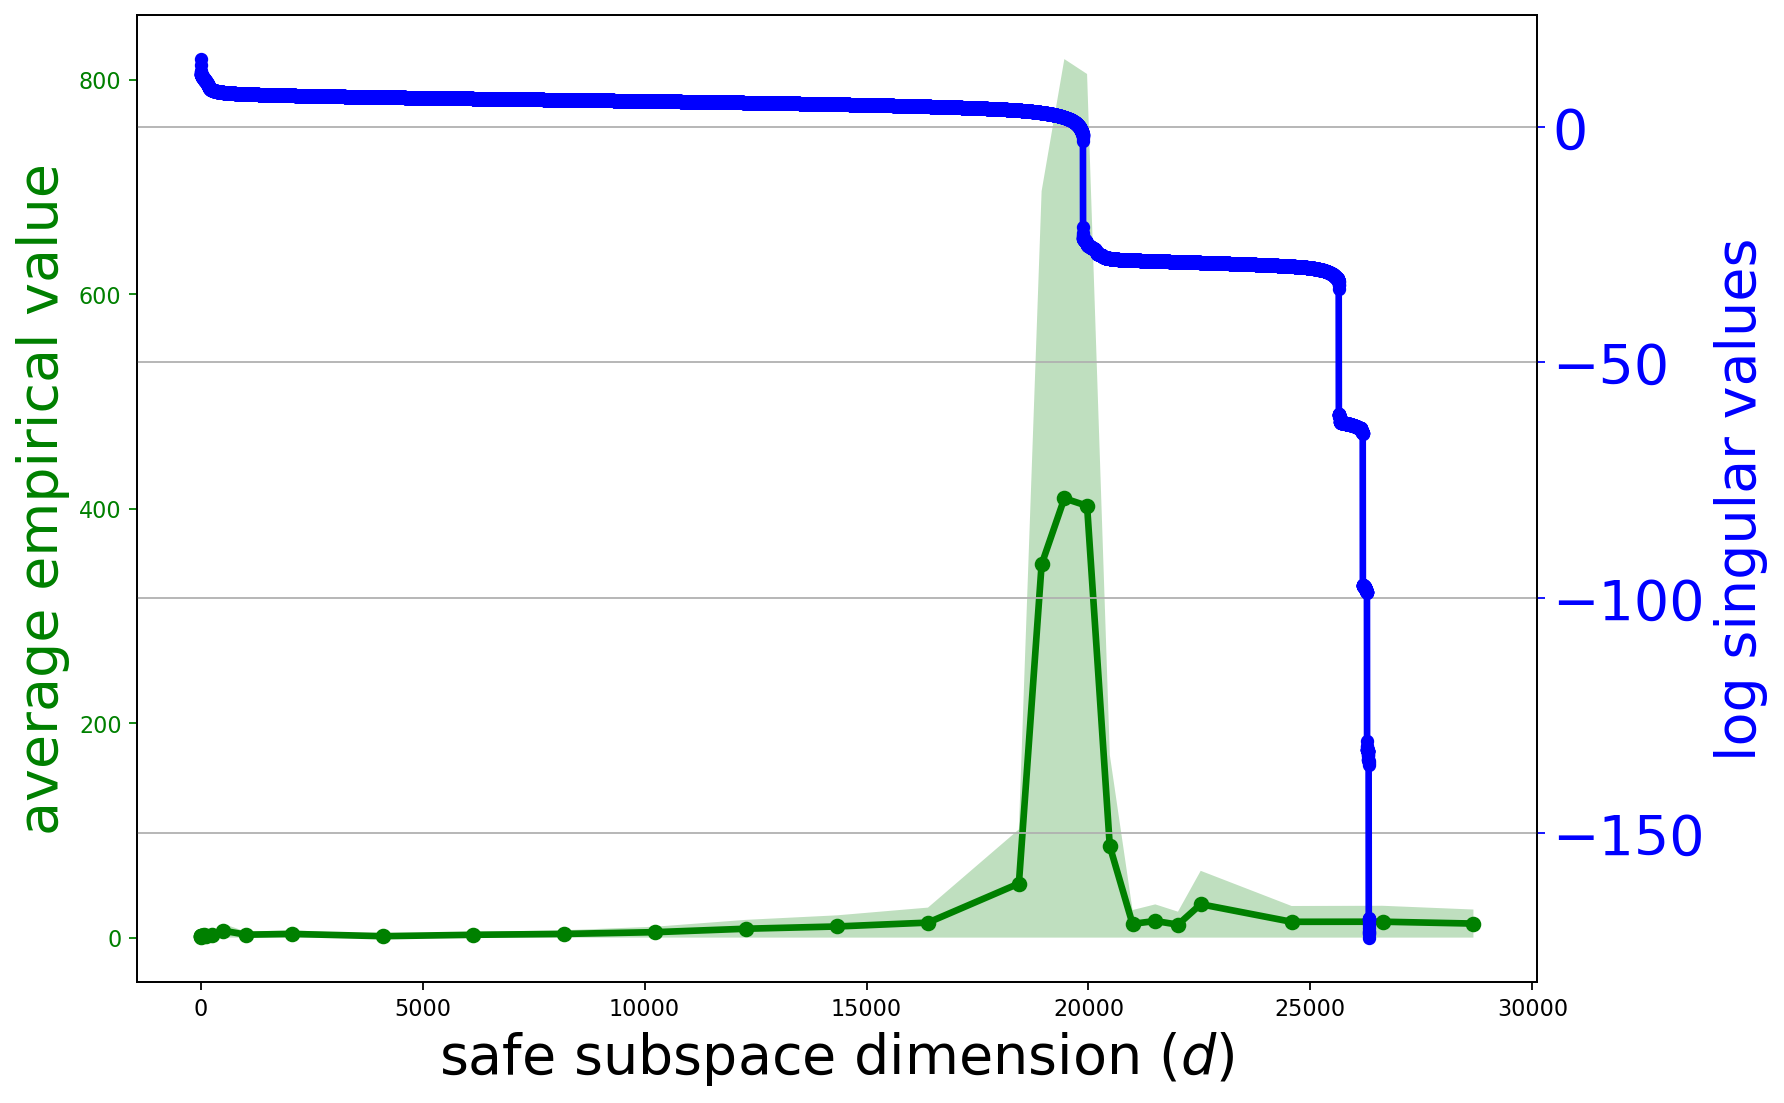

In [8]:
# To make things reproducible...
np.random.seed(1977)

fig, ax = plt.subplots(figsize=(14,8), dpi=160)
plt.rcParams['font.size'] = '25'

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)


# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Green', 'blue')

ax, color = axes[0], colors[0]
ax.plot(sanitizing_sample_count_list, st_return_mean_list, marker='.', linestyle='-', markersize=12, linewidth=3, color=color)
ax.fill_between(sanitizing_sample_count_list, st_return_mean_list-st_return_std_list, st_return_mean_list+st_return_std_list, facecolor='green', alpha=0.25, label='sanitized in trigger env')

ax.set_ylabel('average empirical value', color=color, fontsize=25)
ax.tick_params(axis='y', colors=color)

ax, color = axes[1], colors[1]
ax.plot(np.log(sv), marker='.', markersize=10, linewidth=3, linestyle='-', color=color)
ax.set_ylabel('log singular values', color=color, fontsize=25)
ax.tick_params(axis='y', colors=color)

axes[0].set_xlabel('safe subspace dimension $(d)$', fontsize=25)

plt.grid()
plt.savefig('spectrum_safe_subspace.pdf')
plt.show()